# Buy or Sell Maruti Stocks?

### Algorithmic trading using Dual Moving Average Crossover strategy

In [2]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from datetime import datetime
import yfinance as yf

- I am considering the stocks of Maruti Suzuki (MARUTI)

In [3]:
MARUTI = yf.download('MARUTI.NS',period='5y', progress=False)
MARUTI

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-13,3613.000000,3745.350098,3606.600098,3731.600098,3523.658203,1107727
2016-04-18,3720.800049,3750.000000,3680.000000,3718.949951,3511.712646,999621
2016-04-20,3724.350098,3724.350098,3651.000000,3670.050049,3465.537598,1830988
2016-04-21,3695.000000,3737.250000,3674.000000,3705.300049,3498.823486,1928958
2016-04-22,3703.000000,3833.000000,3680.100098,3816.050049,3603.401855,1165761
...,...,...,...,...,...,...
2021-04-07,6790.000000,6885.000000,6775.049805,6865.000000,6865.000000,598115
2021-04-08,6881.000000,6939.299805,6806.850098,6826.850098,6826.850098,604553
2021-04-09,6850.000000,6875.250000,6778.000000,6827.100098,6827.100098,641327


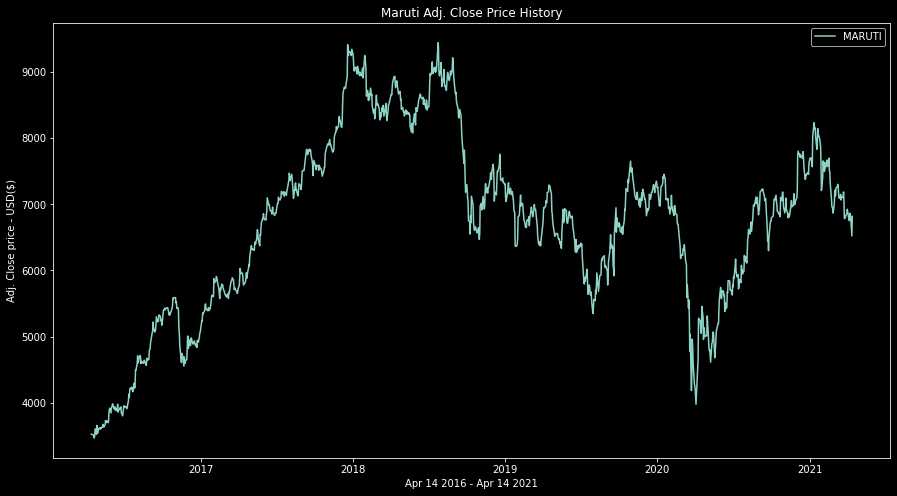

In [4]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(MARUTI['Adj Close'], label='MARUTI')
plt.title('Maruti Adj. Close Price History')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price - USD($)')
plt.legend(loc='best')
plt.show()

## Dual Moving Average Crossover (DMAC) Trading Strategy

- It uses two moving averages, a short period and long period one.
- When the short period moving average crosses over the long period one, a signal is generated to enter the market in the direction of the crossover.
-  if short MA crosses the long MA in an upward direction - BUY signal
-  if short MA crosses the long MA in a downward direction - SELL signal

### DMAC 30/100

In [5]:
# simple moving average with window = 30 days
ma30 = pd.DataFrame()
ma30['Adj Close'] = MARUTI['Adj Close'].rolling(window=30).mean()

# simple moving average with window = 100 days
ma100 = pd.DataFrame()
ma100['Adj Close'] = MARUTI['Adj Close'].rolling(window=100).mean()

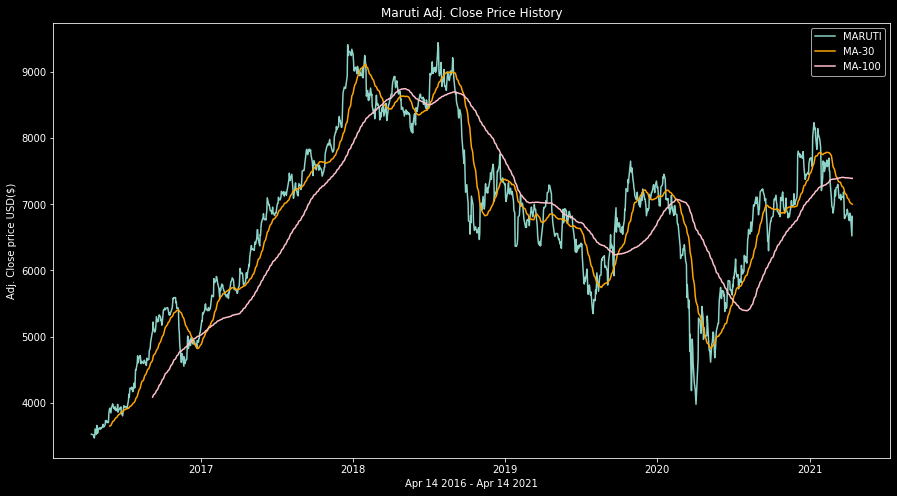

In [6]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(MARUTI['Adj Close'], label='MARUTI')
plt.plot(ma30['Adj Close'], label='MA-30', color='orange')
plt.plot(ma100['Adj Close'], label='MA-100', color='pink')
plt.title('Maruti Adj. Close Price History')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.show()

In [7]:
# creating a new dataframe
df = pd.DataFrame()
df['MARUTI'] = MARUTI['Adj Close']
df['MA30'] = ma30['Adj Close']
df['MA100'] = ma100['Adj Close']
df

,MARUTI,MA30,MA100
Date,,,
2016-04-13,3523.658203,NaN,NaN
2016-04-18,3511.712646,NaN,NaN
2016-04-20,3465.537598,NaN,NaN
2016-04-21,3498.823486,NaN,NaN
2016-04-22,3603.401855,NaN,NaN
...,...,...,...
2021-04-07,6865.000000,7031.548340,7394.723003
2021-04-08,6826.850098,7022.895003,7395.057002
2021-04-09,6827.100098,7018.115007,7394.754502


In [8]:
# buy or sell function

def MA_crossover(data):
  buy_signal = []
  sell_signal = []
  flag = -1 # when the two MA's cross each other

  for i in range(len(data)):
    if data['MA30'][i] > data['MA100'][i]:
      if flag != 1:
        buy_signal.append(data['MARUTI'][i])
        sell_signal.append(np.nan)
        flag = 1
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    elif data['MA30'][i] < data['MA100'][i]:
      if flag != 0:
        buy_signal.append(np.nan)
        sell_signal.append(data['MARUTI'][i])
        flag = 0
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    else:
      buy_signal.append(np.nan)
      sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [9]:
buy_or_sell = MA_crossover(df)
df['buy_signal_price'] = buy_or_sell[0]
df['sell_signal_price'] = buy_or_sell[1]

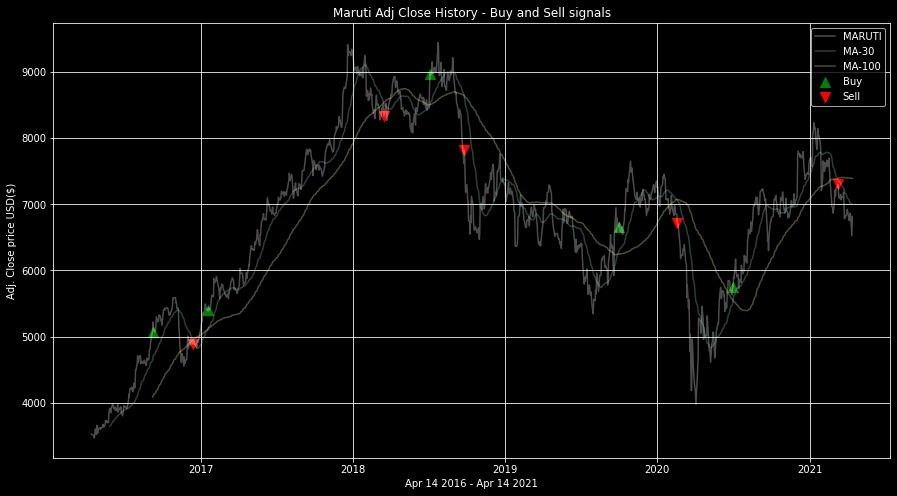

In [10]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(df['MARUTI'], label='MARUTI', alpha=0.30, color='white')
plt.plot(df['MA30'], label='MA-30', alpha=0.30)
plt.plot(df['MA100'], label='MA-100', alpha=0.30)
plt.scatter(df.index, df['buy_signal_price'], label='Buy', marker='^', color='green', s=100)
plt.scatter(df.index, df['sell_signal_price'], label='Sell', marker='v', color='red', s=100)
plt.title('Maruti Adj Close History - Buy and Sell signals')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.grid(b=None)
plt.show()

#### Backtesting - DMAC 30/100 strategy

In [11]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [12]:
class dual_MA_crossover(Strategy):
  def init(self):
    price = self.data.Close
    self.ma1 = self.I(SMA, price, 30)
    self.ma2 = self.I(SMA, price, 100)

  def next(self):
    if crossover(self.ma1, self.ma2):
      self.buy()
    elif crossover(self.ma2, self.ma1):
      self.sell()
  
bt = Backtest(MARUTI, dual_MA_crossover, exclusive_orders=True)

stats = bt.run()
bt.plot()

In [13]:
stats

Start                     2016-04-13 00:00:00
End                       2021-04-13 00:00:00
Duration                   1826 days 00:00:00
Exposure Time [%]                     86.6883
Equity Final [$]                        17863
Equity Peak [$]                       18088.5
Return [%]                            78.6295
Buy & Hold Return [%]                 82.6509
Return (Ann.) [%]                     12.5993
Volatility (Ann.) [%]                 19.1779
Sharpe Ratio                         0.656972
Sortino Ratio                          1.1505
Calmar Ratio                         0.610007
Max. Drawdown [%]                    -20.6544
Avg. Drawdown [%]                     -3.6218
Max. Drawdown Duration      588 days 00:00:00
Avg. Drawdown Duration       48 days 00:00:00
# Trades                                    9
Win Rate [%]                          66.6667
Best Trade [%]                        52.3789
Worst Trade [%]                      -11.3258
Avg. Trade [%]                    

##### Observation:
- DMAC 30/100 - Return - 78%

### DMAC 13/48

In [14]:
# simple moving average with window = 13 days
ma13 = pd.DataFrame()
ma13['Adj Close'] = MARUTI['Adj Close'].rolling(window=13).mean()

# simple moving average with window = 48 days
ma48 = pd.DataFrame()
ma48['Adj Close'] = MARUTI['Adj Close'].rolling(window=48).mean()

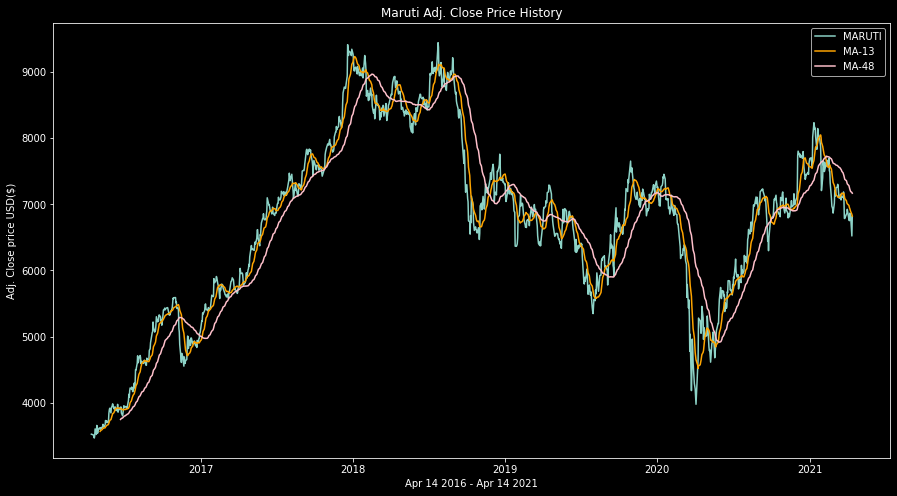

In [15]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(MARUTI['Adj Close'], label='MARUTI')
plt.plot(ma13['Adj Close'], label='MA-13', color='orange')
plt.plot(ma48['Adj Close'], label='MA-48', color='pink')
plt.title('Maruti Adj. Close Price History')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.show()

In [16]:
# creating a new dataframe
df1 = pd.DataFrame()
df1['MARUTI'] = MARUTI['Adj Close']
df1['MA13'] = ma13['Adj Close']
df1['MA48'] = ma48['Adj Close']
df1

,MARUTI,MA13,MA48
2016-04-13,3523.658203,NaN,NaN
2016-04-18,3511.712646,NaN,NaN
2016-04-20,3465.537598,NaN,NaN
2016-04-21,3498.823486,NaN,NaN
2016-04-22,3603.401855,NaN,NaN
...,...,...,...
2021-04-07,6865.000000,6936.311523,7230.562500
2021-04-08,6826.850098,6914.242300,7208.811462
2021-04-09,6827.100098,6892.207707,7192.948964
2021-04-12,6520.600098,6847.542330,7178.656260


In [17]:
# buy or sell function

def MA_crossover(data):
  buy_signal = []
  sell_signal = []
  flag = -1 # when the two MA's cross each other

  for i in range(len(data)):
    if data['MA13'][i] > data['MA48'][i]:
      if flag != 1:
        buy_signal.append(data['MARUTI'][i])
        sell_signal.append(np.nan)
        flag = 1
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    elif data['MA13'][i] < data['MA48'][i]:
      if flag != 0:
        buy_signal.append(np.nan)
        sell_signal.append(data['MARUTI'][i])
        flag = 0
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    else:
      buy_signal.append(np.nan)
      sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [18]:
buy_or_sell = MA_crossover(df1)
df1['buy_signal_price'] = buy_or_sell[0]
df1['sell_signal_price'] = buy_or_sell[1]

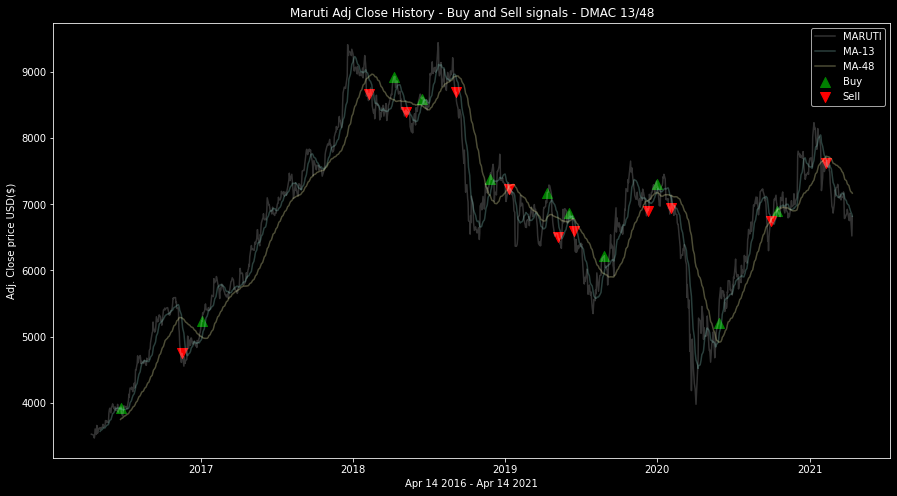

In [19]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(df1['MARUTI'], label='MARUTI', alpha=0.20, color='white')
plt.plot(df1['MA13'], label='MA-13', alpha=0.30)
plt.plot(df1['MA48'], label='MA-48', alpha=0.30)
plt.scatter(df1.index, df1['buy_signal_price'], label='Buy', marker='^', color='green', s=100)
plt.scatter(df1.index, df1['sell_signal_price'], label='Sell', marker='v', color='red', s=100)
plt.title('Maruti Adj Close History - Buy and Sell signals - DMAC 13/48')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.show()

In [20]:
class dual_MA_crossover(Strategy):
  def init(self):
    price = self.data.Close
    self.ma1 = self.I(SMA, price, 13)
    self.ma2 = self.I(SMA, price, 48)

  def next(self):
    if crossover(self.ma1, self.ma2):
      self.buy()
    elif crossover(self.ma2, self.ma1):
      self.sell()
  
bt = Backtest(MARUTI, dual_MA_crossover, exclusive_orders=True)

stats = bt.run()
bt.plot()

In [21]:
stats

Start                     2016-04-13 00:00:00
End                       2021-04-13 00:00:00
Duration                   1826 days 00:00:00
Exposure Time [%]                     88.2305
Equity Final [$]                      21306.4
Equity Peak [$]                       21306.4
Return [%]                            113.064
Buy & Hold Return [%]                 82.6509
Return (Ann.) [%]                     16.7334
Volatility (Ann.) [%]                  20.947
Sharpe Ratio                         0.798847
Sortino Ratio                         1.49547
Calmar Ratio                         0.948183
Max. Drawdown [%]                    -17.6479
Avg. Drawdown [%]                    -3.76947
Max. Drawdown Duration      328 days 00:00:00
Avg. Drawdown Duration       39 days 00:00:00
# Trades                                   23
Win Rate [%]                          47.8261
Best Trade [%]                        42.9838
Worst Trade [%]                      -9.84294
Avg. Trade [%]                    

##### Observation:
- DMAC 13/48 - Return - 113%

### DMAC 50/200

In [22]:
# simple moving average with window = 13 days
ma50 = pd.DataFrame()
ma50['Adj Close'] = MARUTI['Adj Close'].rolling(window=50).mean()

# simple moving average with window = 48 days
ma200 = pd.DataFrame()
ma200['Adj Close'] = MARUTI['Adj Close'].rolling(window=200).mean()

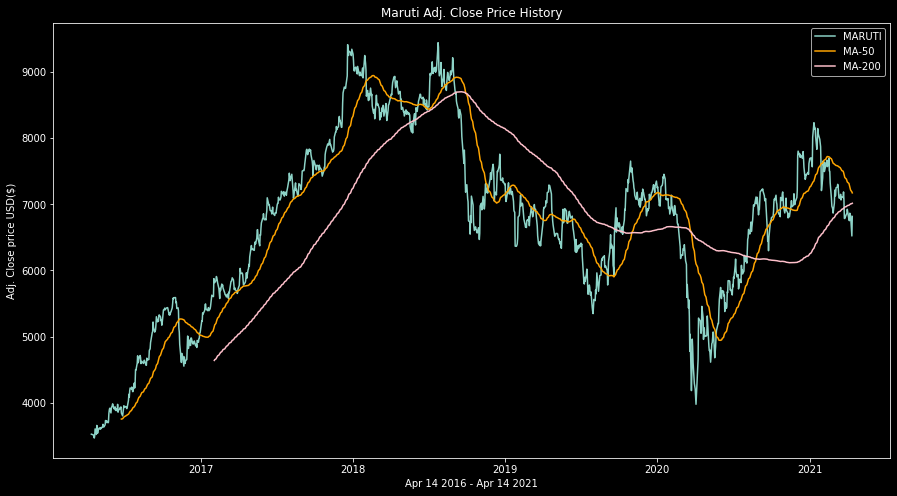

In [23]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(MARUTI['Adj Close'], label='MARUTI')
plt.plot(ma50['Adj Close'], label='MA-50', color='orange')
plt.plot(ma200['Adj Close'], label='MA-200', color='pink')
plt.title('Maruti Adj. Close Price History')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.show()

In [24]:
# creating a new dataframe
df11 = pd.DataFrame()
df11['MARUTI'] = MARUTI['Adj Close']
df11['MA50'] = ma50['Adj Close']
df11['MA200'] = ma200['Adj Close']
df11

,MARUTI,MA50,MA200
2016-04-13,3523.658203,NaN,NaN
2016-04-18,3511.712646,NaN,NaN
2016-04-20,3465.537598,NaN,NaN
2016-04-21,3498.823486,NaN,NaN
2016-04-22,3603.401855,NaN,NaN
...,...,...,...
2021-04-07,6865.000000,7261.947002,6995.724868
2021-04-08,6826.850098,7237.507002,7000.641929
2021-04-09,6827.100098,7214.419004,7005.607317
2021-04-12,6520.600098,7187.413008,7009.690107


In [25]:
# buy or sell function

def MA_crossover(data):
  buy_signal = []
  sell_signal = []
  flag = -1 # when the two MA's cross each other

  for i in range(len(data)):
    if data['MA50'][i] > data['MA200'][i]:
      if flag != 1:
        buy_signal.append(data['MARUTI'][i])
        sell_signal.append(np.nan)
        flag = 1
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    elif data['MA50'][i] < data['MA200'][i]:
      if flag != 0:
        buy_signal.append(np.nan)
        sell_signal.append(data['MARUTI'][i])
        flag = 0
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
    else:
      buy_signal.append(np.nan)
      sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [26]:
buy_or_sell = MA_crossover(df11)
df11['buy_signal_price'] = buy_or_sell[0]
df11['sell_signal_price'] = buy_or_sell[1]

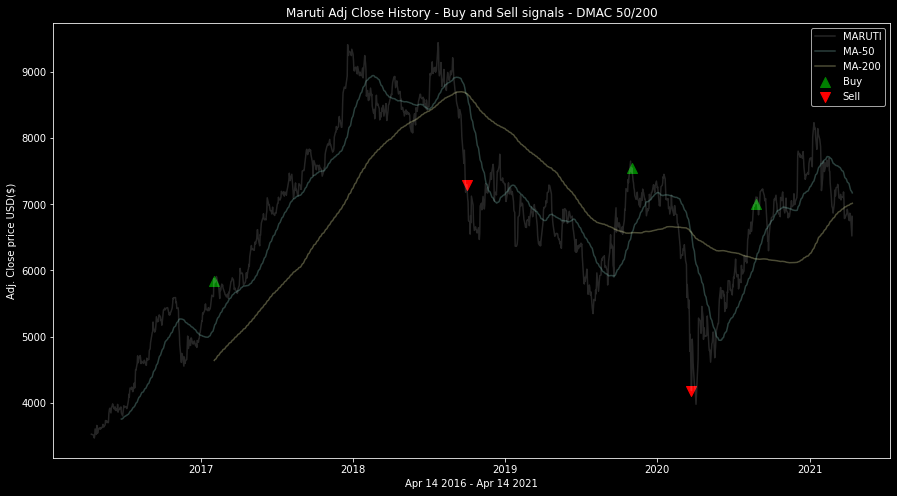

In [27]:
# plotting the data
plt.figure(figsize=(15,8))
plt.plot(df11['MARUTI'], label='MARUTI', alpha=0.15, color='white')
plt.plot(df11['MA50'], label='MA-50', alpha=0.30)
plt.plot(df11['MA200'], label='MA-200', alpha=0.30)
plt.scatter(df11.index, df11['buy_signal_price'], label='Buy', marker='^', color='green', s=100)
plt.scatter(df11.index, df11['sell_signal_price'], label='Sell', marker='v', color='red', s=100)
plt.title('Maruti Adj Close History - Buy and Sell signals - DMAC 50/200')
plt.xlabel('Apr 14 2016 - Apr 14 2021')
plt.ylabel('Adj. Close price USD($)')
plt.legend(loc='best')
plt.show()

In [28]:
class dual_MA_crossover(Strategy):
  def init(self):
    price = self.data.Close
    self.ma1 = self.I(SMA, price, 50)
    self.ma2 = self.I(SMA, price, 200)

  def next(self):
    if crossover(self.ma1, self.ma2):
      self.buy()
    elif crossover(self.ma2, self.ma1):
      self.sell()
  
bt = Backtest(MARUTI, dual_MA_crossover, exclusive_orders=True)

stats = bt.run()
bt.plot()

In [29]:
stats

Start                     2016-04-13 00:00:00
End                       2021-04-13 00:00:00
Duration                   1826 days 00:00:00
Exposure Time [%]                      37.987
Equity Final [$]                         4545
Equity Peak [$]                       12150.3
Return [%]                             -54.55
Buy & Hold Return [%]                 82.6509
Return (Ann.) [%]                     -14.896
Volatility (Ann.) [%]                 15.1276
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -63.1445
Avg. Drawdown [%]                    -9.29684
Max. Drawdown Duration      622 days 00:00:00
Avg. Drawdown Duration       83 days 00:00:00
# Trades                                    3
Win Rate [%]                          33.3333
Best Trade [%]                        3.45144
Worst Trade [%]                      -62.2437
Avg. Trade [%]                    

##### Observation:
- DMAC 50/200 - Return is -54%, which is very bad

## Conclusion

A return of 113% in 5 years is very good, which is obtained by using Dual Moving Average Crossing strategy with short and long windows 13 and 48 respectively.

I used random window lengths. I used 13 and 48 because - "A study discovered that trading the crossovers of the 13-day and 48.5-day averages produced the largest returns". [1]

However - It is up to the trader to choose the number of days to which the two moving averages are set. This should be done after testing and evaluating the system thoroughly in the recommended way, using the trader’s method.


**Note: I am not responsible for any profit/loss you make using this. Do not deploy this strategy without knowing what you are doing, I did this purely for learning purposes, and you should consult your financial advisor before any trading decision! (lol!)**


[1] [Study Determines The Best Moving Average Crossover Trading Strategy](https://finance.yahoo.com/news/study-determines-best-moving-average-195042216.html)